<h1> Optymalizacja Liniowa 2022 | Projekt 1 </h1>
<h2> Arkadiusz Słowik, 417835 </h2>

<h3> Biblioteki </h3>

In [1]:
import numpy as np
from sage.all import *
from itertools import combinations
from string import ascii_lowercase
from itertools import product
from sage.plot.plot3d.shapes import Text
import copy
import math

<h3> Funkcje z zajęć </h3>

In [2]:
# Wyznacznenie wszystkich rozwiązań bazowych dopuszczalnych
def basic_solutions(P: InteractiveLPProblemStandardForm):
    """Compute dictionary of basic feasible solutions of P indexed by basic sets, i.e.
       a mapping <basic set> -> <basic solution>."""
    
    A = P.A()
    n = A.ncols() # number of variables
    m = A.nrows() # number of constraints
    A = A.augment(identity_matrix(m))
    S = dict()
    
    b = P.b()
    for BasicSet in combinations(range(n + m), m):
        AB = A.matrix_from_columns(BasicSet)
        if AB.det() != 0:
            # We found a basic set
           
            x = AB.inverse() * b
            if min(x) >= 0:
                # We found a feasible basic solution
                
                S[BasicSet] = vector(QQ, [x[BasicSet.index(i)] if i in BasicSet else 0 for i in range(n+m)])
    return S

def solution_graph(P: InteractiveLPProblemStandardForm):
    r"""Create a graph (V, E) where
    
    V = set of basic feasible sets of P (vertices of the solution graph),
    E = pairs (B1, B2) of basic feasible sets of P such that #(B1 \ B2) = 1 and #(B2 \ B1) = 1. ###
    
    The edges are oriented in the direction of the gradient of the objective function.
    """
    
    c = vector(QQ, P.c().list() + ([0] * P.A().nrows())) ### wektor funkcji celu z uzupełnionymi zmiennymi zerowymi
    
    S = basic_solutions(P)
    V = set(S)
    print(V)
    E = list()
    for B1 in V:
        for B2 in V:
            S1 = set(B1)
            S2 = set(B2)
            if len(S1.difference(S2)) == 1 and len(S2.difference(S1)) == 1: ### czy jest możliwy pivot
                if c * S[B1] <= c * S[B2]: ### jeżeli wartość na pierwszym wierzchołku jest mniejsza równa na drugim wierzchołku
                    E.append((B1, B2, c * S[B2] - c * S[B1])) ###
   
    g = DiGraph(E)
    return g

# Ta funkcja opisuje wielościan, który jest opisany równaniami naszego problemu
def feasible_polyhedron(P):
    """
    Returns feasible polyhedron of problem P (converted to equational form).
    """
    
    A = P.A()
    b = P.b()

    A = A.augment(identity_matrix(A.nrows()))
    
    eqns = []
    for row, coeff in zip(A, b):    
        eqns.append([-coeff] + list(row)) # wyliczamy równania ( nierówności początkowe łącznie ze zmiennymi dodanymi)

    ieqs = []
    for i in range(A.ncols()): # wyliczamy nierówności, że wszystkie zmienne mają być >= 0
        v = vector(QQ, A.ncols())
        v[i] = 1
        ieqs.append([0] + list(v))
    
    return Polyhedron(ieqs=ieqs, eqns=eqns)

# Graf, że zamiast dużych etykiet, wierzchołki są numerowane kolejnymi literami alfabetu
def labelled_solution_graph(P: InteractiveLPProblemStandardForm):
    c = vector(QQ, P.c().list() + ([0] * P.A().nrows()))

    vname = []
    for length in range(1, 3):
        for combo in product(ascii_lowercase, repeat=length):
            vname.append(''.join(combo))
    
    names = {}
    
    S = basic_solutions(P)
    E = list()
    for n1, B1 in enumerate(S):
        names[B1] = vname[n1]
        
        for n2, B2 in enumerate(S):
            S1 = set(B1)
            S2 = set(B2)
            if len(S1.difference(S2)) == 1 and len(S2.difference(S1)) == 1:
                if c * S[B1] <= c * S[B2]:
                    E.append((vname[n1], vname[n2], c * S[B2] - c * S[B1]))
   
    g = DiGraph(E)
    return g, names


<h3> Generator problemu losowego</h3>

In [3]:
def my_problem_generator(random_seed = None, rows=4, cols=5):
    '''
        Funkcja tworząca losowy problem.
        Sposób: zaczynamy od problemu z 1 nierównością,  jeśli dla takiego problemu istnieje rozwiązanie optymalne, to dobieramy
        kolejną nierówność itd., jeśli nie to wymieniamy nierówność na nową.
    '''
    
    A = np.zeros([rows,cols])
    b = np.zeros(rows)
    c = np.around(random_vector(QQ, cols),10)

    for i in range(rows): # stopniowo sprawdzamy czy po dodaniu kolejnej nierówności wciąż problem ma rozwiązanie, jak nie to wymieniamy współczynniki bierzącej nierówności
        optimal_solution = None
        while optimal_solution == None: 
            b[i] = np.around(np.random.uniform(-10,10,1),10)
            A[i,:] = np.around(np.random.uniform(-10,10,cols),10)
            P = InteractiveLPProblemStandardForm(A[:i+1][:],b[:i+1],c)
            optimal_solution = P.optimal_solution()

    return P,matrix(QQ,A),vector(QQ,b),vector(QQ,c)
    

<h3> Przykładowy problem </h3>
Jest to problem wygenerowany wcześniej moim generatorem.

In [4]:
A = matrix([[ 8.16400563, -9.10787799,  3.99283122],
 [-0.10638895,  5.54050575, -6.12513972],
 [-4.58603428,  7.30373278,  3.33882032],
 [ 8.7390701,   1.9340979,  -8.40780987],
 [ 5.70964092,  6.69254041,  1.54107114]])
b = [3.59395231, 4.76683502, 8.13983192, 9.10759902, 8.48917194]
c = [ -0.5, -1, 0 ]

P = InteractiveLPProblemStandardForm(matrix(A),b,c) # Problem
show(P)

G, name = labelled_solution_graph(P) # Graf
r_name = {b: tuple((x+1 for x in n)) for n, b in name.items()}


LP problem (use typeset mode to see details)

<h3> 1. Ile zbiorów dopuszczalnych? </h3>

In [5]:
def ile_zbiorow_bazowych_dopuszczalnych(P: InteractiveLPProblemStandardForm):
    S = basic_solutions(P) # zbiorow bazowych dopuszczalnych jest tyle samo co rozwiazan dopuszczalnych
    return len(S)
print("Zbiorów bazowych dopuszczalnych jest ",ile_zbiorow_bazowych_dopuszczalnych(P))

Zbiorów bazowych dopuszczalnych jest  12


<h3> 2. Ile możliwych przejść? </h3>

In [6]:
def ile_mozliwych_przejsc(P, G, r_name):
    
    sum = 0
    vertices = list(r_name.keys())
    for i in range(len(vertices)): # iterujemy dla każdego wierzchołka
        D = P.dictionary(*r_name[vertices[i]])
        wspolczynniki_fcelu = list(D.objective_coefficients())
        for j in range(len(wspolczynniki_fcelu)): # jeśli współczynnik przy zmiennej niebazowej dodatni to jest możliwe przejście
            if wspolczynniki_fcelu[j] > 0:
                sum += 1
                
    return sum
        
print("Możliwych przejść metody sympleks jest ",ile_mozliwych_przejsc(P, G, r_name))

Możliwych przejść metody sympleks jest  17


<h3> 3. Czy jest możliwe wejście w cykl? </h3>

In [7]:
def czy_cykl(P, G, r_name):

    lista_przejsc = []
    vertices = list(r_name.keys()) # lista politerowanych wierzchołków

    for i in range(len(vertices)):
        neighbors_out_candidate = G.neighbors_out(vertices[i]) # sąsiadujące wierzchołki
        w = vertices[i] # bieżąca litera
        D = P.dictionary(*r_name[w])
        candidates = D.nonbasic_variables() # wyłapanie zmiennych niebazowych dla zbioru bazowego odpowiadającego bieżącej literze
        for q in range(len(candidates)): # wyłapanie liczb ( zamiast x1 to 1, zamiast x12 to 12 itp.)
            candidates[q] = int(str(candidates[q])[1:])

        in_candidates = {}
        for k in range(len(neighbors_out_candidate)): # znajdujemy jaką liczbę wstawiamy przy przejściu do danej litery
            v = neighbors_out_candidate[k]
            (x_in,) = set(r_name[v]) - set(r_name[w])
            in_candidates[v] = x_in
            in_candidates = dict(sorted(in_candidates.items(), key=lambda item: item[1])) # sortujemy żeby za chwilę odrzucać te x dla których jest zerowy współczynnik, a więc metoda sympleks nie zrobi przejścia, mimo że jest ono na grafie
        
        D = P.dictionary(*r_name[vertices[i]])
        wspolczynniki_fcelu = list(D.objective_coefficients()) # sprawdzamy wspolczynniki przy zmiennych bazowych dla bieżącej litery

        for j in range(len(wspolczynniki_fcelu)): # zabezpieczenie bo może się zdarzyć tak jak w przypadku k vs l, że przy danej zmiennej stoi 0, metoda sympleks nie może wykonać takiego ruchu, więc go eliminujemy
            if wspolczynniki_fcelu[j] > 0: # jeśli faktycznie jest możliwe przejście to dodajemy je do listy
                lista_przejsc.append([w,list(in_candidates.keys())[list(in_candidates.values()).index(candidates[j])]])

    kandydaci_na_cykl = G.all_simple_cycles() # zgarniamy gotową funkcją cykle w grafie

    for i in range(len(kandydaci_na_cykl)): # Sprawdzamy czy jest pośród nich także cykl, który mogłaby wykonać metoda sympleks
        for j in range(1,len(kandydaci_na_cykl[i])):
            przejscie_do_sprawdzenia = [[kandydaci_na_cykl[i][j-1],kandydaci_na_cykl[i][j]]]
            cykl = True
            if przejscie_do_sprawdzenia not in lista_przejsc:
                cykl = False
            if cykl == True:
                return "Mamy cykl."
        
    return "Nie ma cyklu."

print(czy_cykl(P, G, r_name))

Nie ma cyklu.


<h3> 4. Czy zbiór rozwiązań dopuszczalnych jest ograniczony? </h3>

In [8]:
def czy_zbior_rozw_dopuszczalnych_ograniczony(A,b):
    '''
        jeśli optymalne rozwiązanie dla c = [1,0,0...,0], c=[0,1,0,..,0] i c=[0,..0,1] istnieje to oznacza,
        że zbiór rozwiązań dopuszczalnych jest ograniczony
    ''' 
    c_= np.zeros(np.array(A).shape[1])
    nieogr = False
    for i in range(len(c_)): # tworzymy problem i sprawdzamy wartość optymalną
        c = c_
        c[i] = 1
        P = InteractiveLPProblemStandardForm(A,b,c)
        if P.optimal_value()== float('inf'):
            nieogr = True
            break
    if nieogr == True:
        print('Zbiór rozwiązań dopuszczalnych jest nieograniczony')
    else: 
        print('Zbiór rozwiązań dopuszczalnych jest ograniczony')

czy_zbior_rozw_dopuszczalnych_ograniczony(A,b)

Zbiór rozwiązań dopuszczalnych jest ograniczony


<h3> 5. Jak wygląda zbiór rozwiązań dopuszczalnych? </h3>

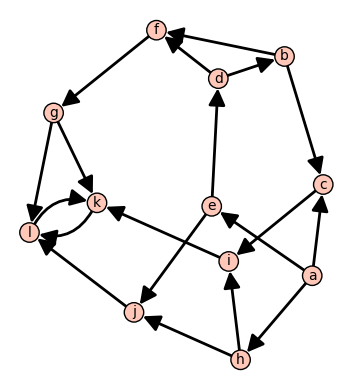

{(0, 1, 2, 3, 6): 'a', (0, 1, 2, 4, 5): 'b', (0, 1, 2, 4, 6): 'c', (0, 1, 3, 4, 5): 'd', (0, 1, 3, 5, 6): 'e', (0, 1, 4, 5, 7): 'f', (0, 4, 5, 6, 7): 'g', (1, 2, 3, 6, 7): 'h', (1, 2, 4, 6, 7): 'i', (1, 3, 5, 6, 7): 'j', (2, 4, 5, 6, 7): 'k', (3, 4, 5, 6, 7): 'l'}


In [9]:
def rysuj_zbior_rozwiazan_dopuszczalnych(P, numerek = 3):
    '''
        Funkcja ilustruje problem w zależności od przyjętej opcji.
        numerek = 1: feasible_polyhedron(P).plot()
        numerek = 2: S.render_wireframe_3d()
        numerek = 3: labelled_solution_graph(P)
    '''
    
    if numerek ==1:
        try:
            show(feasible_polyhedron(P).plot())
        except:
            print('Z powodow numerycznych nie udało się użyć show(feasible_polyhedron(P).plot())')
    elif numerek ==2:
        try:
            F = basic_solutions(P)
            Q = feasible_polyhedron(P)
            R = Q.affine_hull_projection(as_affine_map=True) 
            c = vector(QQ, P.c().list() + [0] * P.A().nrows())
            G, name = labelled_solution_graph(P)
            S = Q.affine_hull_projection().projection()

            show(sum([point(R[0](v) + R[1], size=5, opacity=0.5) for v in F.values()]) + # R[0] macierz, R[1] przesunięcie
                 S.render_wireframe_3d() + 
                 arrow3d(vector(QQ, 3), R[0](c) + R[1], width=0.2) +
                 sum([Text(str(name[w]), color='black').translate(R[0](v) + R[1] + vector([0,1/40,0])) for w, v in F.items()])) # Odpowiednie wyświetlanie nazw wierzchołków
        except:
            print('Z powodow numerycznych nie udało się użyć S.render_wireframe_3d()')
    elif numerek ==3:
            G, name = labelled_solution_graph(P)
            show(G)
            print(name)
        
rysuj_zbior_rozwiazan_dopuszczalnych(P,3)

<h3> 6,7. Metoda sympleks </h3>

In [10]:
def bland_rule(P):
    '''
        Regula Blanda
    '''
    L=copy.deepcopy(P)
    steps = 0
    while L.is_optimal() == False:
        L.enter(L.possible_entering()[0])
        steps+=1
        try:
            L.leave(L.possible_leaving()[0])
            L.update()
        except:
            print('Problem nieograniczony')
            return steps
        #show(P)
    return steps  
    
def largest_coefficient(P,max_steps=50):
    '''
        Wybieramy jako zmienną wchodzącą do bazy zmienną z największym współczynnikiem w funkcji celu.
        Dodatkowo wybieramy zmienną wychodzącą o najmniejszym indeksie.
    '''
    
    L=copy.deepcopy(P)
    steps = 0

    while L.is_optimal() == False: # dopóki nie znaleźliśmy rozwiązania
        wsp_fcelu = list(L.objective_coefficients()) # zgarniamy współczynniki funkcjic celu
        max_value = max(wsp_fcelu) # zgraniamy największy wspólczynnik
        max_index = wsp_fcelu.index(max_value) # znajdujemy odpowiadający mu indeks
        L.enter(L.nonbasic_variables()[max_index]) # wkładamy zmienną o największym współczynniku
        steps+=1
        try:
            L.leave(L.possible_leaving()[0]) ######## narazie liczę dla pierwszej zmiennej wchodzącej, można to zrobić dla wszystkich możliwych rekurencyjnie
            L.update()
        except:
            print('Problem nieograniczony!')
            return steps
        #show(P)
        if steps>=max_steps:
            print('Zapętlenie')
            return steps
    return steps      

def largest_increase(P,max_steps=50):
    '''
        Wybieramy zmienną wchodzącą tak, by zmaksymalizować wzrost wartości funkcji celu.
    '''
    
    L=copy.deepcopy(P)
    steps = 0
    
    while L.is_optimal() == False: # dopóki nie znaleźliśmy rozwiązania
        index = []
        b = L.constant_terms() # współczynniki wolne dla zmiennych bazowych 
        basic_v = L.basic_variables() # zmienne bazowe
        nonbasic_v = L.nonbasic_variables() # zmienne niebazowe
        wsp_fcelu = list(L.objective_coefficients()) # współczynniki przy zmiennych niebazowych
        wartosci = {} # tu będziemy zgarniać wartości b/a dla danej zmiennej niebazowej, z czego weźmiemy minimum
        
        for i in range(len(wsp_fcelu)): # zgarniamy indeksy gdzie wspolczynnik w funkcji celu nie jest ujemny ( sprawdzamy ktore zmienne z kolei mozemy wlozyc)
            if wsp_fcelu[i] >0:
                index.append(i)
        for ind in index: # dla kazdej zmiennej ktora mozemy wlozyc
            wsp_b_a = []
            for j in range(len(basic_v)): # liczymy wspolczynnik max(c * min(b/a)) i dodajemy do slownika
                a = L.row_coefficients(basic_v[j])[ind]
                if a>0: # wspolczynnik a musi byc wiekszy od 0 jesli chcemy wyjac zmienną odpowiadajaca temu wierszowi
                    wsp_b_a.append(b[j]/a)
            try:
                wartosc_min = min(wsp_b_a)
            except:
                wartosc_min = -1
            wartosci[ind] = max(wsp_b_a) * wsp_fcelu[ind]
        
        index_in = max(wartosci, key=wartosci.get) # wyliczamy ktora zmienna z kolei niebazowa wg tej reguly wchodzi do bazy
        
        L.enter(nonbasic_v[index_in]) # wkladamy zmienna do bazy
        steps+=1
        
        try:
            L.leave(L.possible_leaving()[0])
            L.update()
        except:
            print('Problem nieograniczony')
            return steps
        if steps>=max_steps:
            print('Zapętlenie')
            return steps
        
    return steps  
    
def wartosc_zmiennych(L):
    '''
        Funkcja pomocnicza obliczająca wartość wszystkich zmiennych w danym wierzchołku
    '''
    b = L.constant_terms() # współczynniki wolne dla zmiennych bazowych 
    basic_v = L.basic_variables() # zmienne bazowe
    nonbasic_v = L.nonbasic_variables() # zmienne niebazowe
    wsp_fcelu = list(L.objective_coefficients()) # współczynniki przy zmiennych niebazowych
    zmienne = {}
    for j in range(len(basic_v)):
        zmienne[basic_v[j]] = b[j]
    for j in range(len(nonbasic_v)):
        zmienne[nonbasic_v[j]] = 0
    zmienne = np.array(list(dict(sorted(zmienne.items())).values())) # lista po kolei wartosci zmiennych
    return zmienne
    
def steepest_edge(P,max_steps=50):
    '''
        Wybieramy zmienne tak, by kąt pomiędzy krawędzią po której się przesuwamy i gradientem funkcji celu był minimalny.
    '''
    
    steps = 0
    Q = copy.deepcopy(P)
    hm_nonbasic = len(Q.nonbasic_variables()) # wydłużymy c o zmienne slack, przyda się to w formule, której wartości będziemy porównywać
    hm_basic = len(Q.basic_variables())
    zeros = [0] * (hm_nonbasic + hm_basic - len(c))
    longer_c = list(copy.deepcopy(c)) 
    longer_c.extend(zeros)
    
    while Q.is_optimal() == False: # dopóki nie znaleźliśmy rozwiązania
        steps+=1
        zmienne_nowe = [] # tu damy wartości zmiennych jakie uzyskalibyśmy po potencjalnym pivocie
        zmienne_stare = wartosc_zmiennych(Q) # tu wartości zmiennych przed pivotem
        pos_ent = Q.possible_entering() # możliwe wchodzące zmienne niebazowe
        K = []
        for i in range(len(pos_ent)): # tworzymy kopie problemów na których zasymulujemy jakie będą wartości zmiennych po pivocie
            K.append(copy.deepcopy(Q))

        for i in range(len(K)): # liczymy wartości zmiennych po pivocie
            L = K[i]
            L.enter(pos_ent[i])
            try:
                L.leave(L.possible_leaving()[0])
                L.update()
            except:
                print('Problem nieograniczony')
                return steps

            zmienne_nowe.append(wartosc_zmiennych(L))
        score = []
        for k in range(len(K)): # dla każdego potencjalnego pivota liczymy wartość formułki
            score.append(np.array(longer_c).dot((zmienne_nowe[k]-zmienne_stare)/np.linalg.norm(zmienne_nowe[k]-zmienne_stare))) # (***)
        
        max_value = max(score) 
        max_index = score.index(max_value)
        Q.enter(pos_ent[max_index]) # zmienna odpowiadająca pivotowi dla której  kąt
        # pomiędzy krawędzią po której się przesuwamy i gradientem funkcji celu jest minimalny, co odpowiada maksymalizacji ilorazu

        try:
            Q.leave(Q.possible_leaving()[0])
            Q.update()
        except:
            print('Problem nieograniczony')                    
            return steps
        if steps>=max_steps:
            print('Zapętlenie')
            return steps
    return steps

def regula_glodnych_kaczek(P,max_steps=50):
    '''
        Za oknami już wiosna, a jak wiosna to i kaczki. Kaczki karmi się chlebem, a chleb jest lubiany także przez ryby.
        Zdaniem kaczek, kaczki i ryby doszły do porozumienia ( kaczki dały jasno do zrozumienia swoim kwakaniem, że tak ma być i koniec,
        a ryby nie miały nic do powiedzenia), że obie populacje mogą czerpać tylko z 1 źródła rzucanego chleba, przy czym kaczki mają
        pierwszeństwo wyboru.
    
        Ilość chleba rzuconego przez 1 człowieka określa sie jako sumę współczynników a_i odpowiadających danemu człowiekowi( zmiennej
        niebazowej o dodatnim współczynniku funkcji celu), w tabeli reprezentacji.
        Kaczki zawsze wybierają źródło, z którego mają najwięcej chleba.
    '''
    
    L=copy.deepcopy(P)
    steps = 0
    
    while L.is_optimal() == False: # dopóki nie znaleźliśmy rozwiązania
        index = []
        b = L.constant_terms() # współczynniki wolne dla zmiennych bazowych 
        basic_v = L.basic_variables() # zmienne bazowe
        nonbasic_v = L.nonbasic_variables() # zmienne niebazowe
        wsp_fcelu = list(L.objective_coefficients()) # współczynniki przy zmiennych niebazowych
        wartosci = {} # tu będziemy zgarniać wartości b/a dla danej zmiennej niebazowej, z czego weźmiemy minimum
        
        for i in range(len(wsp_fcelu)): # zgarniamy indeksy gdzie wspolczynnik w funkcji celu nie jest ujemny ( sprawdzamy ktore zmienne z kolei mozemy wlozyc)
            if wsp_fcelu[i] >0:
                index.append(i)
        for ind in index: # dla kazdej zmiennej ktora mozemy wlozyc
            wsp_a = []
            a = 0
            for j in range(len(basic_v)): # liczymy wspolczynnik max(a) i dodajemy do slownika
                a += L.row_coefficients(basic_v[j])[ind]
            wsp_a.append(a)
            wartosc_max = max(wsp_a)
            wartosci[ind] = wartosc_max
        
        index_in = max(wartosci, key=wartosci.get) # wyliczamy ktora zmienna z kolei niebazowa wg tej reguly wchodzi do bazy
        
        L.enter(nonbasic_v[index_in]) # wkladamy zmienna do bazy
        steps+=1
        
        try:
            L.leave(L.possible_leaving()[0])
            L.update()
        except:
            print('Problem nieograniczony')
            return steps
        if steps>=max_steps:
            print('Zapętlenie')
            return steps
        
    return steps  
    

def calculations(wyniki):
    '''
        Funkcja do liczenia maksymalnej i średniej ilości kroków metod.
    '''
    
    max_avg = []
    wyniki = np.array(wyniki)
    for i in range(len(wyniki[0])):
        max_avg.append([np.max(wyniki[:,i]),int(np.around(np.average(wyniki[:,i])))])
    return max_avg
    
def table(wierzcholki,wyniki, rezultaty):
    '''
        Funkcja wyswietlająca analizę metod.
    '''
    
    print("Legenda: ")
    print("Br : Blands rule")
    print("Li : Largest increase")
    print("Lc : Largest coefficient")
    print("Se : Steepest edge")
    print("Rg : Reguła głodnych kaczek")
    print("")
    txt = " {0}| {1}| {2}| {3}| {4}| {5}|".format("Wierzchołek","Br", "Li", "Lc", "Se", "Rg")
    print(txt)
    print("---------------------------------")
    for i in range(len(wierzcholki)):
        jaki_odstep = 5 - len(wierzcholki[i])
        odstep = '  '  * jaki_odstep
        txt = "{0}{1} | {2} | {3} | {4} | {5} | {6} |".format(wierzcholki[i],odstep, wyniki[i][0], wyniki[i][1], wyniki[i][2], wyniki[i][3], wyniki[i][4])
        print(txt)
    print("")
    
    txt = "{0}  | {1} | {2} | {3} | {4} | {5} |".format("Max kroków", rezultaty[0][0], rezultaty[1][0], rezultaty[2][0], rezultaty[3][0], rezultaty[4][0])
    print(txt)
    txt = "{0}  | {1} | {2} | {3} | {4} | {5} |".format("Avg kroków", rezultaty[0][1], rezultaty[1][1], rezultaty[2][1], rezultaty[3][1], rezultaty[4][1])
    print(txt)

def my_simplex_method(P,G,name):
    '''
        Główna funkcja metody sympleks. Zawiera metody i analizę.
    '''
    
    wierzcholki = np.array(list((name.keys()))) + 1 # +1 bo wierzchołki grafu maja indeksowanie od 0
    feasibles = []
    scores = []
    
    for i in range(len(wierzcholki)):
        
        D = P.dictionary(*wierzcholki[i])
        
        if D.is_feasible()==True:

            feasibles.append(wierzcholki[i])

            br = bland_rule(D)
            li = largest_increase(D)
            lc = largest_coefficient(D)
            se = steepest_edge(D)
            rg = regula_glodnych_kaczek(D)
            
            score = [br, lc, li, se, rg]
            scores.append(score)
            
    rezultaty = calculations(scores)
    
    return feasibles,scores, rezultaty

feasibles,scores, rezultaty = my_simplex_method(P,G,name)

table(feasibles,scores, rezultaty)
        

Legenda: 
Br : Blands rule
Li : Largest increase
Lc : Largest coefficient
Se : Steepest edge
Rg : Reguła głodnych kaczek

 Wierzchołek| Br| Li| Lc| Se| Rg|
---------------------------------
[1 2 3 4 7] | 4 | 3 | 3 | 3 | 7 |
[1 2 3 5 6] | 4 | 3 | 4 | 4 | 4 |
[1 2 3 5 7] | 3 | 3 | 3 | 3 | 3 |
[1 2 4 5 6] | 4 | 4 | 3 | 3 | 4 |
[1 2 4 6 7] | 5 | 2 | 2 | 2 | 5 |
[1 2 5 6 8] | 2 | 2 | 2 | 2 | 2 |
[1 5 6 7 8] | 2 | 2 | 1 | 1 | 1 |
[2 3 4 7 8] | 2 | 2 | 2 | 2 | 2 |
[2 3 5 7 8] | 1 | 1 | 1 | 1 | 1 |
[2 4 6 7 8] | 1 | 1 | 1 | 1 | 1 |
[3 5 6 7 8] | 0 | 0 | 0 | 0 | 0 |
[4 5 6 7 8] | 0 | 0 | 0 | 0 | 0 |

Max kroków  | 5 | 4 | 4 | 4 | 7 |
Avg kroków  | 2 | 2 | 2 | 2 | 2 |


<h3> Bonusowa funkcja: czy mamy skończenie wiele rozwiązań? </h3>

In [11]:
def czy_sk_liczba_rozw_optymalnych(P):
    '''
        jeśli wyliczyliśmy rozwiązanie optymalne i niebazowa zmienna ma współczynnik równy 0, to jeśli ją włożymy do bazy,
        to dostaniemy drugie rozwiązanie, a co za tym idzie cała krawędź pomiędzy wierzchołkami będzie rozwiązaniem
        jest to świetnie przedstawione na przykładzie Multiple Optimal Solutions:
    '''

    if 0 in list(P.optimal_solution()):
        print('Nieskończona liczba rozwiązań optymalnych.') 
    else:
        print('Skończona liczba rozwiązań optymalnych.')
czy_sk_liczba_rozw_optymalnych(P)

Nieskończona liczba rozwiązań optymalnych.


<h3> Narzędzia do analizy złożoności </h3>

In [12]:
def smalltable(wyniki, rezultaty):
    '''
        Funkcja wyswietlająca skrótową analizę metod.
    '''
    
    print("Legenda: ")
    print("Br : Blands rule")
    print("Li : Largest increase")
    print("Lc : Largest coefficient")
    print("Se : Steepest edge")
    print("Rg : Reguła głodnych kaczek")
    print("")
    
    txt = "{0}  | {1} | {2} | {3} | {4} | {5} |".format("Max kroków", rezultaty[0][0], rezultaty[1][0], rezultaty[2][0], rezultaty[3][0], rezultaty[4][0])
    print(txt)
    txt = "{0}  | {1} | {2} | {3} | {4} | {5} |".format("Avg kroków", rezultaty[0][1], rezultaty[1][1], rezultaty[2][1], rezultaty[3][1], rezultaty[4][1])
    print(txt)

def analizuj(jak=0,ile=1, bstart=4, cstart=3):
    '''
    Funkcja generująca kilka przykładów wraz z ich krótką analizą.
    
    jak : 0 - zwiekszamy tylko ilosc nierownosci, 1 - zwiekszamy tylko ilosc zmiennych, 2 - zwiekszamy to i to, 3 - staly problem
    ile : ile przykladow wygenerowac
    bstart : ile nierownosci na poczatek
    cstart : ile zmiennych na poczatek
    '''
    
    if jak==0:
        for i in range(ile):
            P,A,b,c = my_problem_generator(1,bstart+i,cstart)
            print('Wygenerowany problem ',i+1)
            G, name = labelled_solution_graph(P)
            r_name = {b: tuple((x+1 for x in n)) for n, b in name.items()}

            feasibles,scores, rezultaty = my_simplex_method(P,G,name)

            smalltable(scores, rezultaty)
    elif jak ==1:
        for i in range(ile):
            P,A,b,c = my_problem_generator(1,bstart,cstart+i)
            print('Wygenerowany problem ',i+1)
            G, name = labelled_solution_graph(P)
            r_name = {b: tuple((x+1 for x in n)) for n, b in name.items()}

            feasibles,scores, rezultaty = my_simplex_method(P,G,name)

            smalltable(scores, rezultaty)
    elif jak ==2:
        for i in range(ile):
            P,A,b,c = my_problem_generator(1,bstart+i,cstart+i)
            print('Wygenerowany problem ',i+1)
            G, name = labelled_solution_graph(P)
            r_name = {b: tuple((x+1 for x in n)) for n, b in name.items()}

            feasibles,scores, rezultaty = my_simplex_method(P,G,name)

            smalltable(scores, rezultaty)
    elif jak ==3:
        for i in range(ile):
            P,A,b,c = my_problem_generator(1,bstart,cstart)
            print('Wygenerowany problem ',i+1)
            G, name = labelled_solution_graph(P)
            r_name = {b: tuple((x+1 for x in n)) for n, b in name.items()}

            feasibles,scores, rezultaty = my_simplex_method(P,G,name)

            smalltable(scores, rezultaty)
analizuj(1,1,2,2)

Wygenerowany problem  1
Legenda: 
Br : Blands rule
Li : Largest increase
Lc : Largest coefficient
Se : Steepest edge
Rg : Reguła głodnych kaczek

Max kroków  | 3 | 2 | 2 | 2 | 2 |
Avg kroków  | 2 | 1 | 1 | 1 | 1 |


<h3> Bibliografia </h3>
- Przedmiot MIMUW Optymalizacja Liniowa:

https://usosweb.mimuw.edu.pl/kontroler.php?_action=katalog2/przedmioty/pokazPrzedmiot&prz_kod=1000-135OPL&callback=g_ce5ae490